In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#to read the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
block_size = 3 # this represents how many letters of context the model considers before choosing the next letter
def build_dataset(words):
    X, Y = [], []

    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [11]:
# from the previous code
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in the hidden layers

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g) #embeddings
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size) ** 0.5)# * 0.2 # best number to put this is divide by fanim (sqrt(n_embd * block_size))
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [13]:
# cleaner version of mlp1
max_steps = 200000
batch_size = 32
lossi = []
 
for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass 
    emb = C[Xb] # embeds characters into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate vectors
    # linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # Batch norm layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # batch normalization
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    # Non-linearity activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output
    loss = F.cross_entropy(logits, Ytr[ix]) # loss
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < max_steps/2 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats for lr
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3013
  10000/ 200000: 2.0035
  20000/ 200000: 2.0043
  30000/ 200000: 2.0937
  40000/ 200000: 2.2616
  50000/ 200000: 2.1408
  60000/ 200000: 2.0564
  70000/ 200000: 2.3588
  80000/ 200000: 2.3619
  90000/ 200000: 2.2137
 100000/ 200000: 2.3094
 110000/ 200000: 1.8927
 120000/ 200000: 2.2329
 130000/ 200000: 2.0224
 140000/ 200000: 1.7848
 150000/ 200000: 2.3820
 160000/ 200000: 2.2525
 170000/ 200000: 1.7767
 180000/ 200000: 1.9479
 190000/ 200000: 2.2804


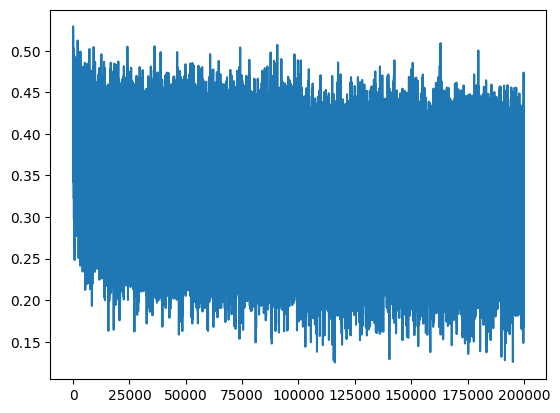

In [14]:
plt.plot(lossi)

In [15]:
# calibrate batch norm at the end of training
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [16]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias 
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.066694736480713
val 2.1048972606658936


My loss log:

Original: \
train 2.1247687339782715 \
val 2.1666340827941895

High initial loss + tanh saturation fix: \
train 2.0355966091156006 \
val 2.1026782989501953

Adding a batch norm layer \
train 2.0668270587921143\
val 2.104844808578491

In [10]:
g = torch.Generator().manual_seed(2147483647 + 11)
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        #forward pass
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        
        #sample from probability distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        
        #shift the context window and track samples
        context = context[1:] + [ix]
        out.append(ix)
        
        # break for the '.'
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))

sulyannnchnz.
sgbrayseardnn.
saksramzisabdryxtch.
fllsx.
subishamnyas.
braysissavlryshthell.
zadestlftiednn.
briansxabrdustr.
sanshugschbaslugfjelynanbell.
shissaddn.
khaylizzuquslefn.
slusofhnssocqstraeshugskeczidra.
srafgiyah.
santh.
afditycindsousglestya.
shamdam.
samrshfrishbnn.
srxandva.
sasdestaveenatth.
madmariesslyctmdri.


Comments:

Improper initialization:
    
    At initialization, we are starting with very high number losses like 27. This is because of the way we are initializing it randomly; it is better to just assign probabilities evenly. 
    
    One thing to note though is that if you set them all as even, 

Activation function giving tons of edge cases:
    
    We are killing the gradient because 1 - t^2 is the backpropagation of the chain rule. In other words since t = 1 or -1, when we multiply this value by out.grad, we are turning it into 0, effectively nullifying any changes this can make. This means that by activating the function, more and more of our input are claiming to be perfect enough such that we would not need to even change them.
    
Doesn't use Batch Normalization

    We want the hidden states to be roughly gaussian to minimize saturated values. Too small numbers -> tanh is inactive. Too large numbers -> tanh is saturated. Why don't we just normalize the the preactivation such that its just gaussian? Paper from google about batch normalization. 
    
    One thing is that we don't want to just normalize them and force hpreact to be gaussian every time. We want the model to be able to make changes, make certain nodes more trigger happy, etc. We won't get a very good result by forcing this. So we have to introduce this additional component in the paper called scale and shift. We need to scale the batch normalizaton by some gains, and then offset it by some biases. 
    
    Since we are doing this, we will need to include the gains and biases in our backpropagation so our program will update it. 
    
    In our case, we only have a single hidden layer, so our batch normalization was not doing much. The kaiming factor kind of did everything for us instead. In larger examples, batch normalization is much better for stablizing the training.

    In standard neural networks, each example is processed independently, but batch normalization couples them by using the batch's mean and variance. This breaks the assumption of independent data points, which makes the math harder to analyze and less elegant. It also causes a mismatch between training and inference behavior, since different statistics are used in each phase. Additionally, batch norm performs poorly with small batch sizes due to noisy estimates of mean and variance. However, this "jitter" with normally larger batch sizes acts as a regularizer that improves generalization and prevents overconfident, overfitted learning.
    
    Batch normalization is one of the first normalization techniques to be used. Many people want to remove it or replace it with other normalization techniques since but unsuccessfully as it is also very useful at creating that noise that helps the program.

    When conducting batch normalization, b1 becomes useless because we are subtracting by the means after adding the bias. Since we are adding a batch normalization bias anyways after, we dont need b1.  
    

Deep learning motif: \
Convolutional layer/Weight layer/Linear layer, Batch normalization, non-linearity

no one likes bn because it couples examples and cuases tons of bugs. more common is root normalization or layer normalization.

# TIME TO PYTORCH-IFY THE CODE

In [25]:
# HAHAHAHAHA

class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5 # Kaiming factor
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backpropagation)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers with momentum
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        #update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
# layers = [
#     Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#     Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size), 
# ]

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1
    #layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [26]:
# cleaner version of mlp1
max_steps = 200000
batch_size = 32
lossi = []
ud = []
 
for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass 
    emb = C[Xb] # embeds characters into vectors
    x = emb.view(emb.shape[0], -1) #concatenate vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < max_steps/2 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats for lr
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    
    if i > 5000:
        break # debug purposes only

      0/ 200000: 3.2990


Three things learned
- Batch norm

    Batch Normalization standardizes the output of a layer by subtracting the batch mean and dividing by the batch standard deviation, then scaling and shifting it using learnable parameters γ and β.
    
- pytorchify the code, use modules as building blocks, everything was built such that it matches pytorch api and you can just prepend nn to everything 
- Diagnostic tools used to understand whether the neural net is in a good state dynamically

Activation Distributions (Forward Pass): \
Healthy activations are centered near zero with a moderate spread. If many activations cluster near the extremes (±1 for Tanh), it means saturation—neurons output constant values and stop learning. Increasing saturation across layers signals weakening signals as they move forward.

layer 1 (      Tanh): mean +0.04, std 0.76, saturated: 20.34%
layer 3 (      Tanh): mean -0.01, std 0.76, saturated: 18.41%
layer 5 (      Tanh): mean -0.00, std 0.78, saturated: 21.53%
layer 7 (      Tanh): mean -0.05, std 0.79, saturated: 19.09%
layer 9 (      Tanh): mean +0.00, std 0.71, saturated: 13.09%


Text(0.5, 1.0, 'activation distribution')

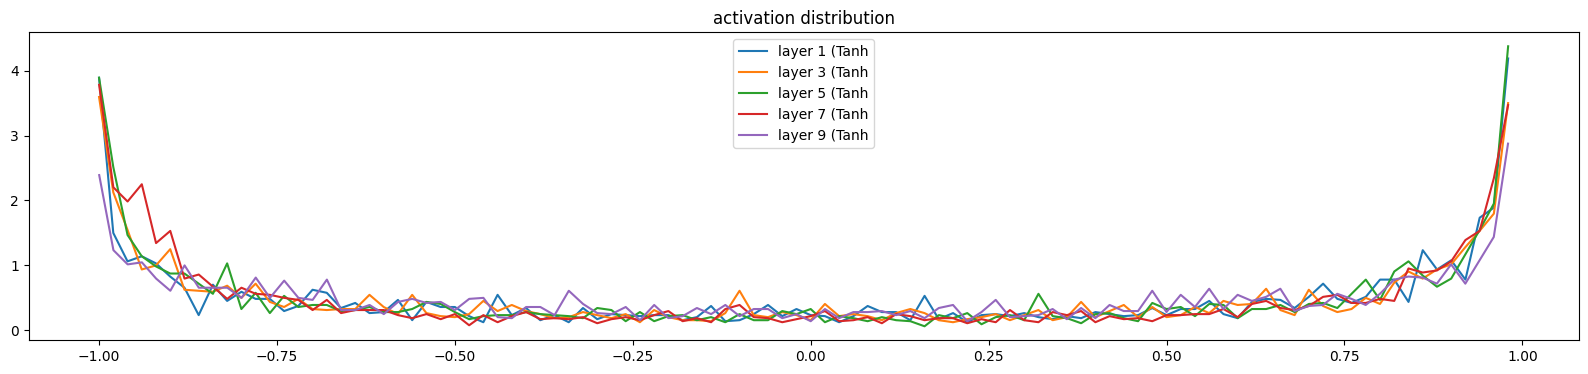

In [27]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

using batch norm

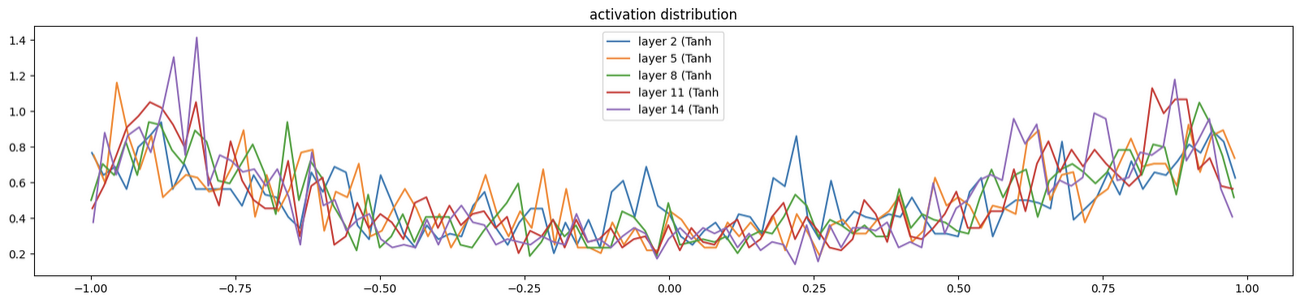

gain 1:

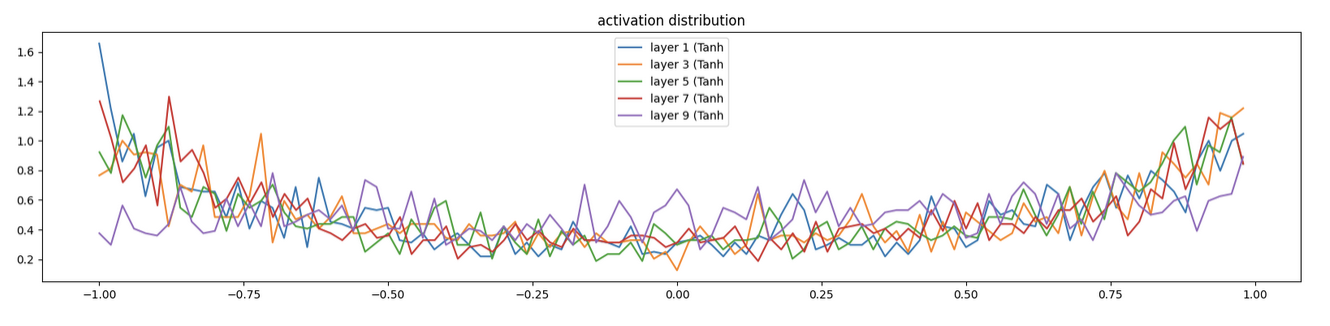

gain 5/3
    
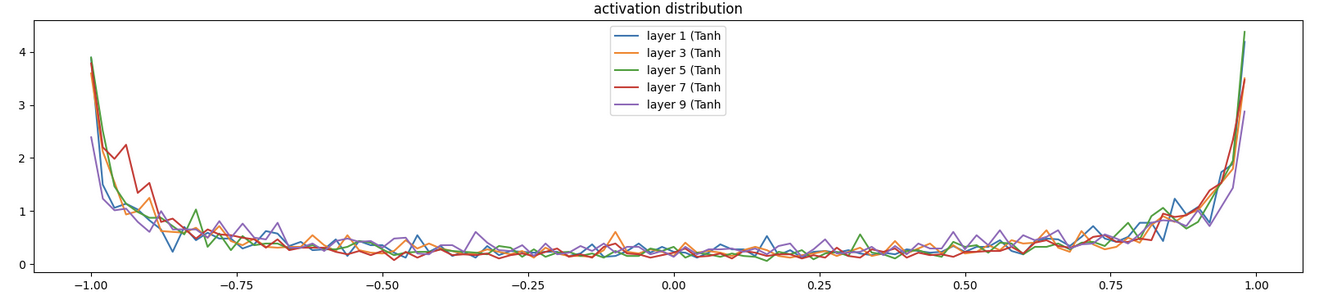

Activation Gradients: \
Good gradient distributions have a decent spread and nonzero mean. If gradients vanish (near zero) in early layers, those layers stop learning. Very large or erratic gradients indicate exploding gradients, which destabilize training.

layer 2 (      Tanh): mean -0.000000, std 4.531010e-03
layer 5 (      Tanh): mean +0.000000, std 4.341498e-03
layer 8 (      Tanh): mean -0.000000, std 3.900736e-03
layer 11 (      Tanh): mean -0.000000, std 3.700389e-03
layer 14 (      Tanh): mean +0.000000, std 3.467584e-03


Text(0.5, 1.0, 'gradient distribution')

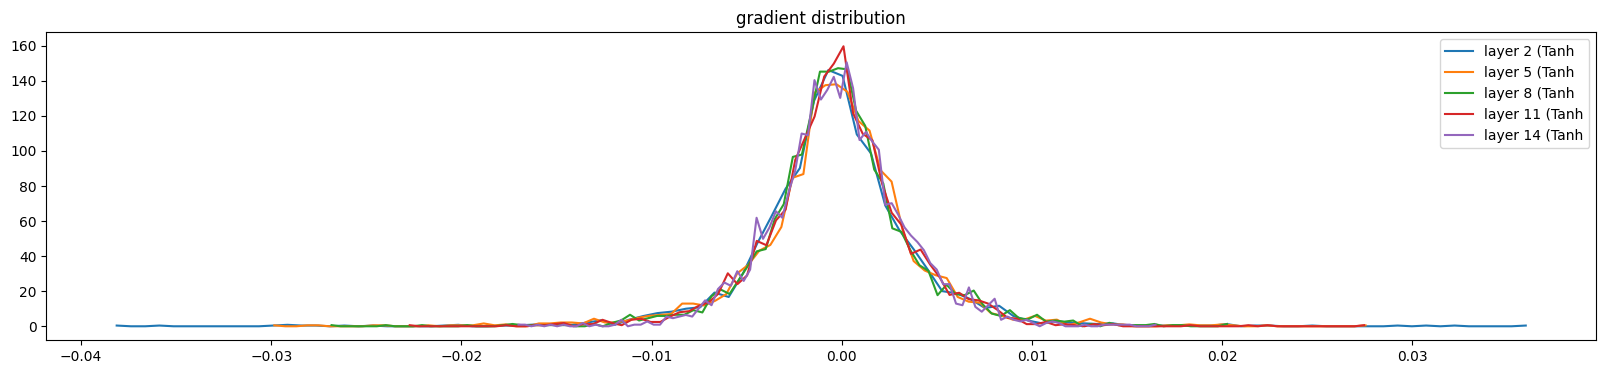

In [14]:


# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')



Parameter Gradients: \
Weight gradients should be reasonably spread and centered near zero. Narrow or tiny gradients mean slow learning in that layer, while excessively large gradients can cause instability. The grad-to-weight ratio around 1e-3 indicates balanced updates.

weight   (27, 10) | mean +0.000000 | std 1.761405e-02 | grad:data ratio 1.606040e-02
weight  (30, 100) | mean -0.000073 | std 1.045013e-02 | grad:data ratio 2.571874e-02
weight (100, 100) | mean -0.000013 | std 6.579952e-03 | grad:data ratio 2.642464e-02
weight (100, 100) | mean -0.000014 | std 6.247401e-03 | grad:data ratio 2.538475e-02
weight (100, 100) | mean -0.000056 | std 5.520657e-03 | grad:data ratio 2.298126e-02
weight (100, 100) | mean +0.000007 | std 5.118837e-03 | grad:data ratio 2.199100e-02
weight  (100, 27) | mean +0.000064 | std 9.072421e-03 | grad:data ratio 2.694347e-02


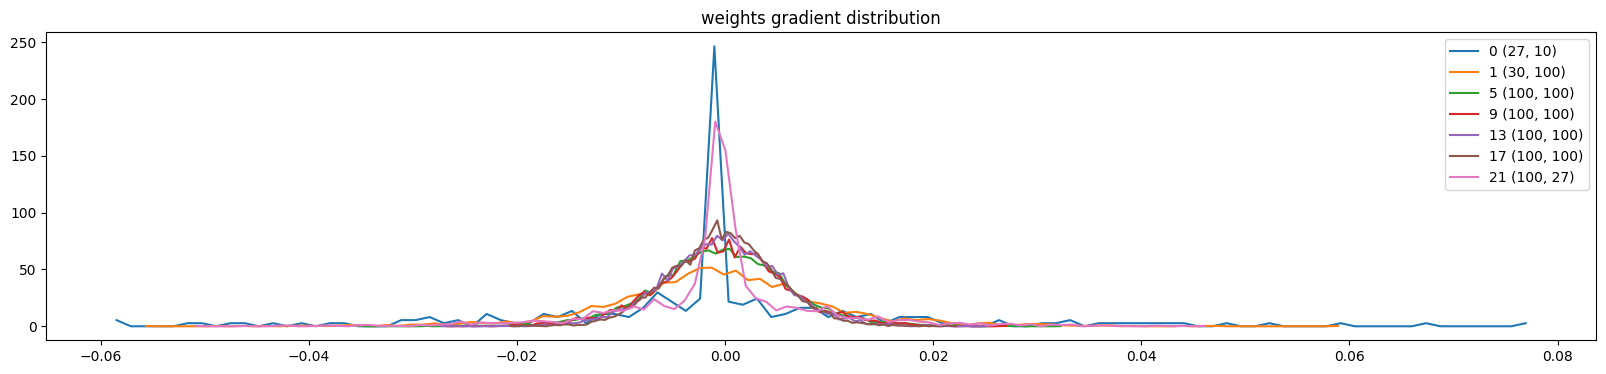

In [15]:


# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');



Update-to-Weight Ratios Over Time: \
Stable training shows these ratios hovering near 1e-3 for all layers. Ratios drifting too high cause unstable updates; too low cause stagnation. Divergent patterns between layers suggest unbalanced learning and potential training issues.

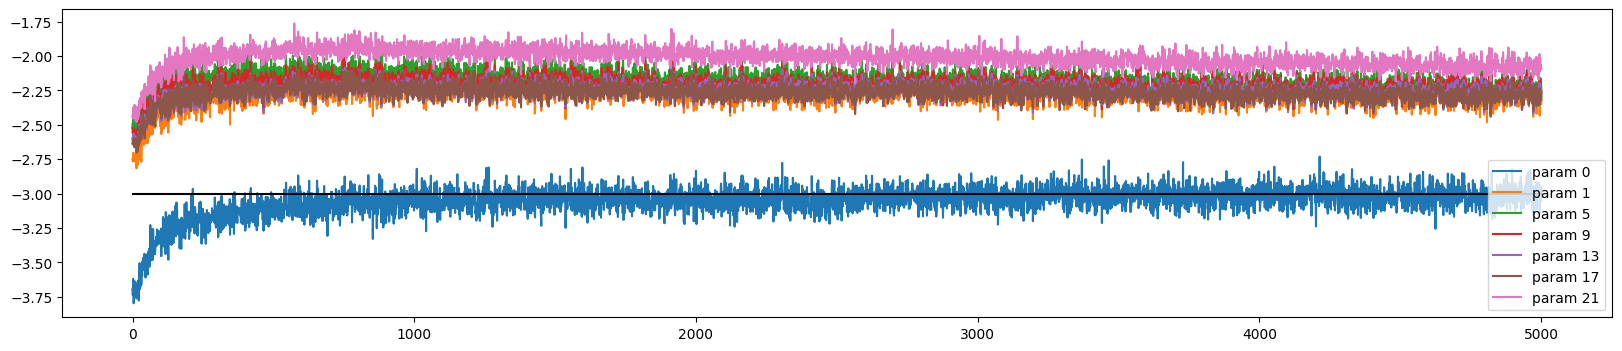

In [20]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

Before batch normalization, training deep networks required careful weight initialization, low learning rates, and non-saturating activations like ReLU. Without this, activations could explode or vanish, especially with tanh or sigmoid, making gradients unstable. Deep networks were hard to train and often failed to converge without tricks like gradient clipping or layer-wise pretraining.

Batch normalization changed this by actively stabilizing the distributions of activations during training. By normalizing each layer’s outputs (mean ≈ 0, std ≈ 1) and then scaling and shifting with learnable parameters, BatchNorm keeps neurons operating in a healthy range regardless of weight initialization or input distribution. It makes training deeper networks easier and more reliable, even with poor initialization.

